In [1]:
from UNetKerasReshapePreserve import UNet
import tensorflow as tf
import copy
import itertools

/home/jd/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Generalized Model Info for scalability
# { id : {'prev_layer' : [str], 'output_shape': [int], 'next_layer' : [str] }}
# { 'model_order': [str]}
def get_model_info(model):
    model_info = {}
    graph = model.get_config()['layers']
    for layer_info in graph[::-1]:
        layer_name = layer_info['name']
        input_layers = layer_info['inbound_nodes']
        if len(input_layers):
            input_layers = [l[0] for l in input_layers[0]]
        else:
            input_layers = []

        # Fill the prev_layer
        if layer_name not in list(model_info.keys()):
            model_info[layer_name] = {}
        model_info[layer_name]['prev_layer'] = copy.deepcopy(input_layers)

        # Fill output_shape
        output_shape = list(model.get_layer(name=layer_name).output_shape)
        if len(output_shape) == 1:
            output_shape = [i for i in output_shape[0] if i]
        elif len(output_shape) > 1:
            output_shape = [i for i in output_shape if i]
        else:
            output_shape = []
        model_info[layer_name]['output_shape'] = copy.deepcopy(output_shape)

        # Fill next_layer of current input_layer
        for input_layer in input_layers:
            # Generate first time
            if input_layer not in list(model_info.keys()):
                model_info[input_layer] = {}
            if 'next_layer' not in list(model_info[input_layer].keys()):
                model_info[input_layer]['next_layer'] = []

            model_info[input_layer]['next_layer'].append(layer_name)

    model_info['model_order'] = copy.deepcopy([layer_info['name'] for layer_info in graph])

    return model_info

In [ ]:
# def get_sliced_model_info():
    

In [ ]:
for i in range(0,5):
    if i == 0:
        model = UNet(3, 1, 16,[])
    else:
        model = UNet(3, 1, 16,[i])
    batch_size = 1
    img_size = (512,512)
    model.build(input_shape=(batch_size,img_size,3))

    # Get all node informations
    # get model info 
    model_info = get_model_info(model)

    model_order = model_info['model_order']
    candidates_points = list(range(len(model_order)))[1:-1]
    partition_combinations = itertools.combinations(candidates_points, 2)

    # fill stack with destination nodes in reverse order (end, ...)
    end_node_stack = []

    
    # iterate from first to end

        # if this node in stack -> end


In [ ]:


graph = model.get_config()['layers']
layer_dependency = {}
layer_require_data_size = {}
sliced_data_require = {}

# It is easy to track a dependency when a list inversed
# This program shows how the data will take if we slice right before the node.
for layer_info in graph[::-1]:
    layer_name = layer_info['name']
    input_layers = layer_info['inbound_nodes']
    if len(input_layers):
        input_layers = [l[0] for l in input_layers[0]]

    # layer_input_shape = mlayer.input_shape
    # layer_output_shape = mlayer.output_shape

    # First pop myself in layer dependency
    layer_dependency.pop(layer_name, None)

    # Insert my input layers
    for input_layer in input_layers:
        input_data_shape = list(model.get_layer(name=input_layer).output_shape)
        if len(input_data_shape) == 1:
            input_data_shape = [i for i in input_data_shape[0] if i]
        elif len(input_data_shape) > 1:
            input_data_shape = [i for i in input_data_shape if i]
        else:
            input_data_shape = []
        layer_dependency[input_layer] = input_data_shape
    sliced_data_require[layer_name] = copy.deepcopy(layer_dependency)
    
sliced_data_require[model.layers[0].name] = {'input' :[*img_size,3]}

for layer in model.layers:
    req_data_shape = sliced_data_require[layer.name]
    data_size = 0
    for k in req_data_shape:
        tmp_sz = 1
        for r in req_data_shape[k]:
            tmp_sz *= r
        data_size += tmp_sz
    print(layer.name, data_size)

In [ ]:
graph = model.get_config()['layers']
layer_require_data_size = {}
sliced_data_require = {}
skip_connection = []
output_stack = [graph[-1]['name']]
insert_current_layer = False
prev_src_node = []

# It is easy to track a dependency when a list inversed
# This program shows how the data will take if we slice right before the node.
for layer_info in graph[::-1]:
    layer_name = layer_info['name']
    input_layers = layer_info['inbound_nodes']
    if len(input_layers):
        input_layers = [l[0] for l in input_layers[0]]

    if insert_current_layer:
        src_layer = [i for i in prev_src_node if i != layer_name]
        src_layer = src_layer[0]
        cur_output_shape = model.get_layer(name=layer_name).output_shape
        if len(cur_output_shape) == 1:
            cur_output_shape = [i for i in cur_output_shape[0] if i]
        elif len(input_data_shape) > 1:
            cur_output_shape = [i for i in cur_output_shape if i]
        output_stack.append([layer_name, cur_output_shape])
        insert_current_layer = False

    # This is the destination of skip connection, then flag on and next input layer would be into the stack
    if len(input_layers) > 1:
        prev_src_node = copy.deepcopy(input_layers)
        insert_current_layer = True

    # First pop myself in layer dependency
    layer_dependency = {}

    # Insert my input layers
    for input_layer in input_layers:
        input_data_shape = list(model.get_layer(name=input_layer).output_shape)
        if len(input_data_shape) == 1:
            input_data_shape = [i for i in input_data_shape[0] if i]
        elif len(input_data_shape) > 1:
            input_data_shape = [i for i in input_data_shape if i]
        else:
            input_data_shape = []
        layer_dependency[input_layer] = input_data_shape
    sliced_data_require[layer_name] = copy.deepcopy(layer_dependency)
    
sliced_data_require[model.layers[0].name] = {'input' :[*img_size,3]}

for layer in model.layers:
    req_data_shape = sliced_data_require[layer.name]
    data_size = 0
    for k in req_data_shape:
        tmp_sz = 1
        for r in req_data_shape[k]:
            tmp_sz *= r
        data_size += tmp_sz
    print(layer.name, data_size)

In [1]:
from UNetKerasReshapePreserve import UNet
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import time
os.environ [ "TF_FORCE_GPU_ALLOW_GROWTH" ] = "true"

In [7]:
batch_size = 4
img_size = (256,256)
in_dim = 3
out_dim = 1
num_filters = 16
epochs=100

def DataGenerator(data_gen_args, path, random_seed, target_size, batch_size, color_mode='rgb', subset='training'):
    image_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    # data_gen = image_gen.flow_from_directory(path, class_mode=None, target_size=target_size, color_mode=color_mode, shuffle=True, seed=random_seed, batch_size=batch_size, subset=subset)
    data_gen = image_gen.flow_from_directory(path, class_mode=None, target_size=target_size, color_mode=color_mode, shuffle=False, batch_size=batch_size)
    return data_gen

data_gen_args = dict(
    rescale=1./255,
)
# dataset_type = ['train', 'validation', 'test']
base_path = os.environ.get("TS_DATA_PATH", "")
raw_data_path = base_path + "/us-bmod/{}/raw"
mask_data_path = base_path + "/us-bmod/{}/mask"


x_test = DataGenerator(data_gen_args, raw_data_path.format('test'), random_seed=1, target_size=img_size, batch_size=batch_size)

data_gen_args = dict(
    rescale=1./255,
    preprocessing_function = lambda x: np.where(x>0, 255, 0).astype(x.dtype)
)

y_test = DataGenerator(data_gen_args, mask_data_path.format('test'), random_seed=1, target_size=img_size, color_mode='grayscale', batch_size=batch_size)

data_generator_test = zip(x_test, y_test)

Found 161 images belonging to 1 classes.
Found 161 images belonging to 1 classes.


In [3]:
for n in range(15):
    print("#########")
    model_path = model_base + "model_{}th_512.h5"
    print()
    for i in range(0, 5):
        model = keras.models.load_model(model_path.format(i))
        x_test.reset()
        y_test.reset()
        data_generator_test = zip(x_test, y_test)
        results = model.evaluate(data_generator_test, batch_size=32, steps=len(x_test), verbose=0)
        print(i, "th test loss :",  results[0])

#########



OSError: SavedModel file does not exist at: ./model_0/model_0th_512.h5/{saved_model.pbtxt|saved_model.pb}

In [6]:
model_base = "./model_3/"
model_path = model_base + "model_{}th_512.h5"
for i in range(0, 5):
    model = keras.models.load_model(model_path.format(i))
    results = model.evaluate(data_generator_test, batch_size=32, steps=len(x_test))
    print(i, "th : test loss, test acc:",  results)

41/41 [==============================] - 12s 290ms/step - loss: 0.4264 - binary_crossentropy: 0.4264
0 th : test loss, test acc: [0.4264119267463684, 0.4264119267463684]
41/41 [==============================] - 12s 289ms/step - loss: 0.4067 - binary_crossentropy: 0.4067
1 th : test loss, test acc: [0.40667250752449036, 0.40667250752449036]
41/41 [==============================] - 12s 287ms/step - loss: 0.4564 - binary_crossentropy: 0.4564
2 th : test loss, test acc: [0.45640385150909424, 0.45640385150909424]
41/41 [==============================] - 12s 290ms/step - loss: 0.4074 - binary_crossentropy: 0.4074
3 th : test loss, test acc: [0.40744853019714355, 0.40744853019714355]
41/41 [==============================] - 12s 288ms/step - loss: 0.4433 - binary_crossentropy: 0.4433
4 th : test loss, test acc: [0.4432607591152191, 0.4432607591152191]


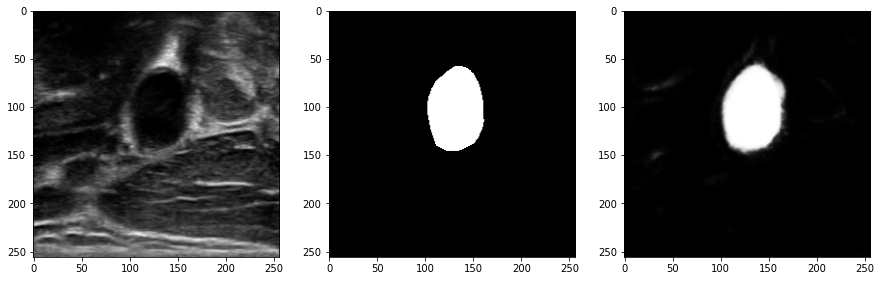

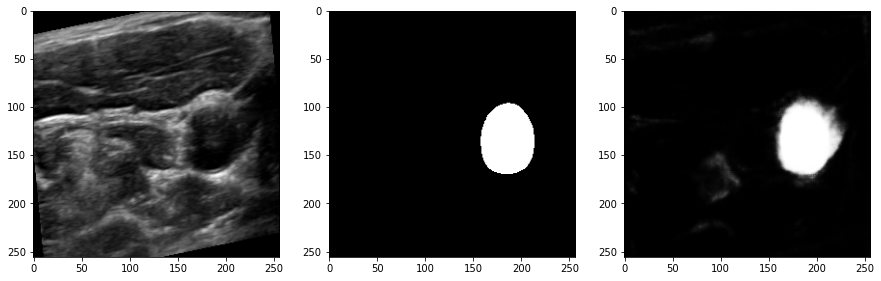

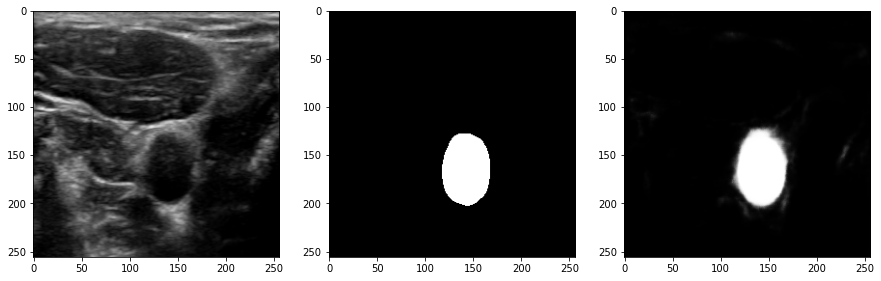

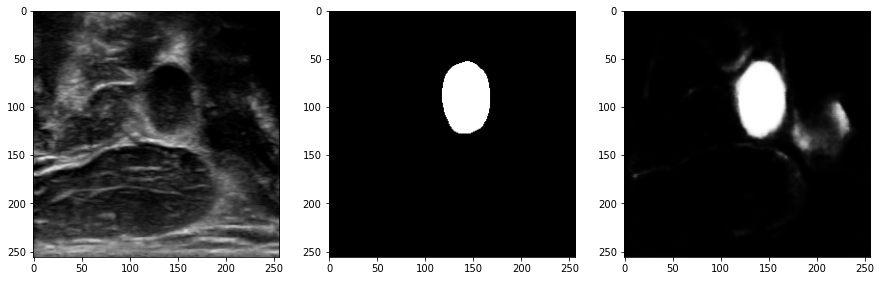

In [12]:
# Load some data
for i, (image_data, mask_data) in enumerate(data_generator_test):
    break
model_path = "UNet_M[2-0-0-0].h5"

model = keras.models.load_model(model_path)

for i, (image, mask) in enumerate(zip(image_data, mask_data)):
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(1,3,1)
    plt.imshow((image*255).astype(np.uint8) ,cmap='gray')
    fig.add_subplot(1,3,2)
    plt.imshow((mask).astype(np.uint8), cmap='gray')
    fig.add_subplot(1,3,3)
    result = model.predict(np.array([image]))
    pred_mask = result[0]
    plt.imshow((np.array(pred_mask*255)).astype(np.uint8), cmap='gray')
    plt.show()
    if i == 5:
        break